In [134]:
# pip install pandas_datareader
# pip install yfinance

In [183]:
%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

# Data Sources
from pykrx import stock, bond
from pandas_datareader import data as pdr
import yfinance as yf
from konlpy.tag import *
from wordcloud import WordCloud
import requests

def normalize(df, column):
    '''데이터프레임과 해당 컬럼을 넣어주면 min_max scale 된 컬럼을 반환합니다.'''
    
    return (df[column] - df[column].min()) / (df[column].max() - df[column].min())

def word_cloud_jtb(df):
    '''크롤링 데이터를 넣어주면, worldcloud 시각화를 출력합니다. 반환값은 없습니다.'''
    
    # 크롤링한 데이터 제목별로 뽑아오기
    words = ' '.join(df['제목'])

    # 불용어 사전으로 데이터 정제
    stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
    remove_list = [';', ',', '[삭제된 게시물의 답글]', '.', '/', '`', '(', ')','[', ']', '늘', '답글', '게시', '원전', '두산', '공도', '개미', '글삭', '주식',
                    '외인', '기관', '대통', '간다', '우디', '지금', '진짜', '스팸', '집트']
    stopwords.extend(remove_list)
    for stopword in stopwords:
        words = words.replace(stopword[0], '')

    # konlp 활용해서 명사 뽑기
    okt = Okt()
    noun = okt.nouns(words)
    new_words = []
    
    # 명사가 한 글자인 경우 넣지 않기
    for i in noun:
        if len(i.strip()) != 1:
            new_words.append(i)
    new_words = ' '.join(new_words)

    # 한글자
    wc = WordCloud(collocation_threshold= int(1e6),
                    width = 800, height = 400,
                    background_color = 'lightgrey',
                    font_path = 'C:/miniproject_1/font/SeoulNamsanB.ttf').generate(new_words)

    plt.figure(figsize = (16,9))

    # x, y축을 그리지 않습니다.
    plt.axis("off")

    # grid lines를 그리지 않습니다.
    plt.grid(False)
    plt.imshow(wc)
    plt.show()

def set_font(fontPath, fontname):
    '''fontPath와 fontname을 입력하면 폰트를 세팅합니다. 반환 값은 없습니다.'''
    # 시각화 폰트
    # 폰트 파일 다운로드 받아서 경로 설정한 곳에 저장
    font_dir = [fontPath] 
    for font in font_manager.findSystemFonts(fontpaths=font_dir):
        print(mpl.font_manager.FontProperties(fname=font).get_name()) # 폰트명 확인
        font_manager.fontManager.addfont(font) # 폰트 추가

    # get_name을 통해서 나온 폰트명을 추가
    # Set font family globally
    mpl.rcParams['font.family'] = fontname # 이름 확인 된걸 추가
    print(mpl.rcParams['font.family'])

def upbit_api():
        days = 3000 # 최근 n일의 데이터 수집
        idx =  'UBMI' # 인덱스명
        url = 'https://crix-api-cdn.upbit.com/v1/crix/candles/days?code=IDX.UPBIT.' + idx + '&count=' + str(days)
        response = requests.get(url)
        data = requests.get(url).json()
        ubmi = pd.DataFrame(data)
        ubmi.drop(['candleDateTimeKst','openingPrice','highPrice','lowPrice','candleAccTradeVolume', 'candleAccTradePrice',
                'timestamp', 'code', 'prevClosingPrice', 'change', 'changePrice',
                'signedChangePrice', 'changeRate', 'signedChangeRate'],axis=1,inplace=True)
        ubmi.rename(columns={'candleDateTime':'Date','tradePrice':'Close'},inplace=True)
        ubmi.Date = ubmi.Date.apply(lambda x: x.split('T')[0])
        ubmi.Date = pd.to_datetime(ubmi.Date)
        ubmi = ubmi.sort_values(by = 'Date')
        return ubmi
    
# 폰트 설정
set_font('C:/miniproject_1/font','SeoulNamsan')
# 야후 파이낸스 관련 데이터
yf.pdr_override()

# 데이터 불러오기
kr_base_rate_df = pd.read_csv('C:/miniproject_1/data/한국은행 기준금리.csv', encoding = 'utf-8-sig').T
result_df = pd.read_csv('naver_ds.csv')
df_sector = pd.read_csv('C:/miniproject_1/data/섹터별_20000101_20220901.csv',encoding='cp949').drop(columns='Unnamed: 0')

NanumGothic
Noto Serif KR
Noto Serif KR
Noto Serif KR
SeoulNamsan
Noto Serif KR
Noto Serif KR
SeoulNamsan
NanumGothic
Noto Serif KR
NanumGothic
Noto Serif KR
['SeoulNamsan']


## 코스피/금/석유/국내 그림 추이 비교

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


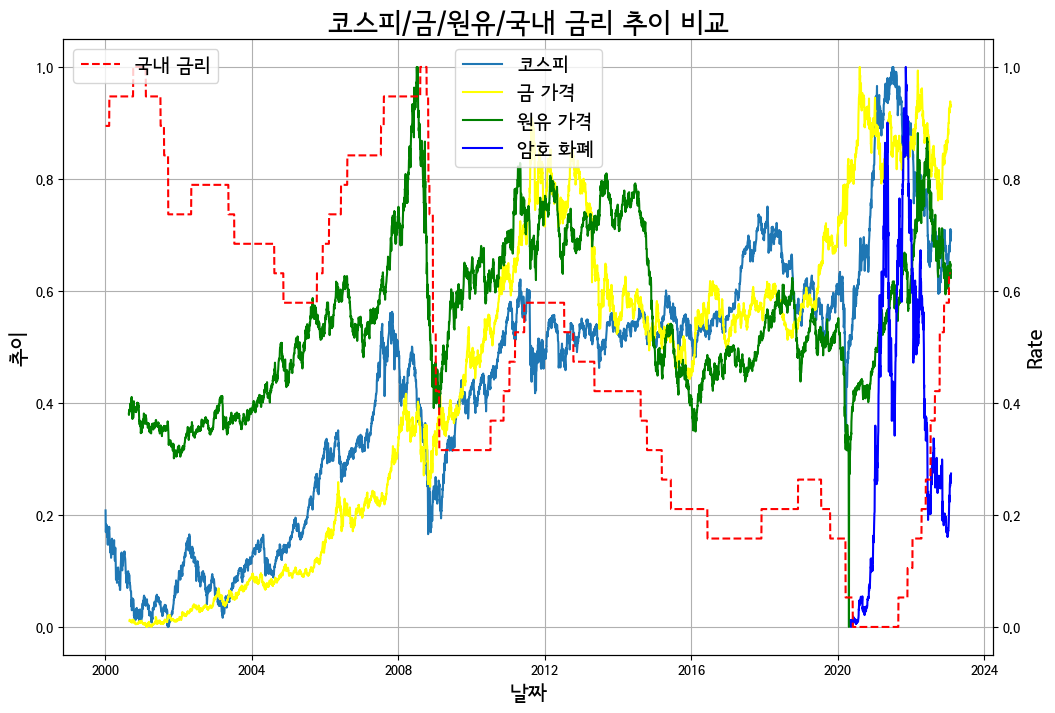

In [180]:
# 날짜 설정
now = datetime.now()
start_day = datetime(2000,1,1)
end_day = datetime(now.year,now.month,now.day)

# 코스피 데이터, 금 시세, 석유 시세
kospi_df = stock.get_index_fundamental(start_day.strftime('%Y%m%d'), end_day.strftime('%Y%m%d'), "1001") # 코스피
gold_df  = pdr.get_data_yahoo('GC=F', start_day, end_day) # 금
oil_df = pdr.get_data_yahoo('CL=F', start_day, end_day) # 석유

# 한국 이자율
kr_base_rate_df = pd.read_csv('C:/miniproject_1/data/한국은행 기준금리.csv').T
# 비트코인
upbit_price = upbit_api()

# 전처리
kospi_price = kospi_df['종가'].reset_index().rename(columns = {'날짜' : 'Date', '종가' : 'Close'})
gold_price = gold_df['Close'].reset_index()
oil_price = oil_df['Close'].reset_index()
kr_base_rate = kr_base_rate_df.iloc[4:].reset_index().rename(columns = {'index' : 'Date', 0 : 'Rate'})
kr_base_rate['Date'] = pd.to_datetime(kr_base_rate['Date'])

# 정규화
kospi_price['Close'] = normalize(kospi_price, 'Close')
gold_price['Close'] = normalize(gold_price, 'Close')
oil_price['Close'] = normalize(oil_price, 'Close')
upbit_price['Close'] = normalize(upbit_price, 'Close')
kr_base_rate['Rate'] = normalize(kr_base_rate, 'Rate')

# 시각화

fig = plt.figure(figsize = (12, 8))

ax1 = sns.lineplot(
    data= kospi_price,
    x = 'Date',
    y = 'Close',
    label = '코스피'
)

ax1 = sns.lineplot(
    data= gold_price,
    x = 'Date',
    y = 'Close',
    label = '금 가격',
    color = 'yellow'
)

ax1 = sns.lineplot(
    data= oil_price,
    x = 'Date',
    y = 'Close',
    color = 'green',
    label = '원유 가격',
)

ax1 = sns.lineplot(
    data= upbit_price,
    x = 'Date',
    y = 'Close',
    color = 'blue',
    label = '암호 화폐'
)


plt.title('코스피/금/원유/국내 금리 추이 비교', fontdict = {'fontsize' : 20})
plt.legend(loc = 'upper center', fontsize = 14)
plt.ylabel('추이', fontsize= 15)
plt.xlabel('날짜', fontsize= 15)
plt.grid() # 배경선 표시

ax2 = ax1.twinx() # x축 공유
ax2 = sns.lineplot(
    data = kr_base_rate,
    y = 'Rate',
    x = 'Date',
    color = 'red',
    linestyle='--')
plt.legend(['국내 금리'], loc = 'upper left', fontsize = 14)
plt.ylabel('Rate', fontsize = 15)
plt.show()


# 산업군별 주가 상관계수

<AxesSubplot:title={'center':'산업군별 주가 상관계수'}>

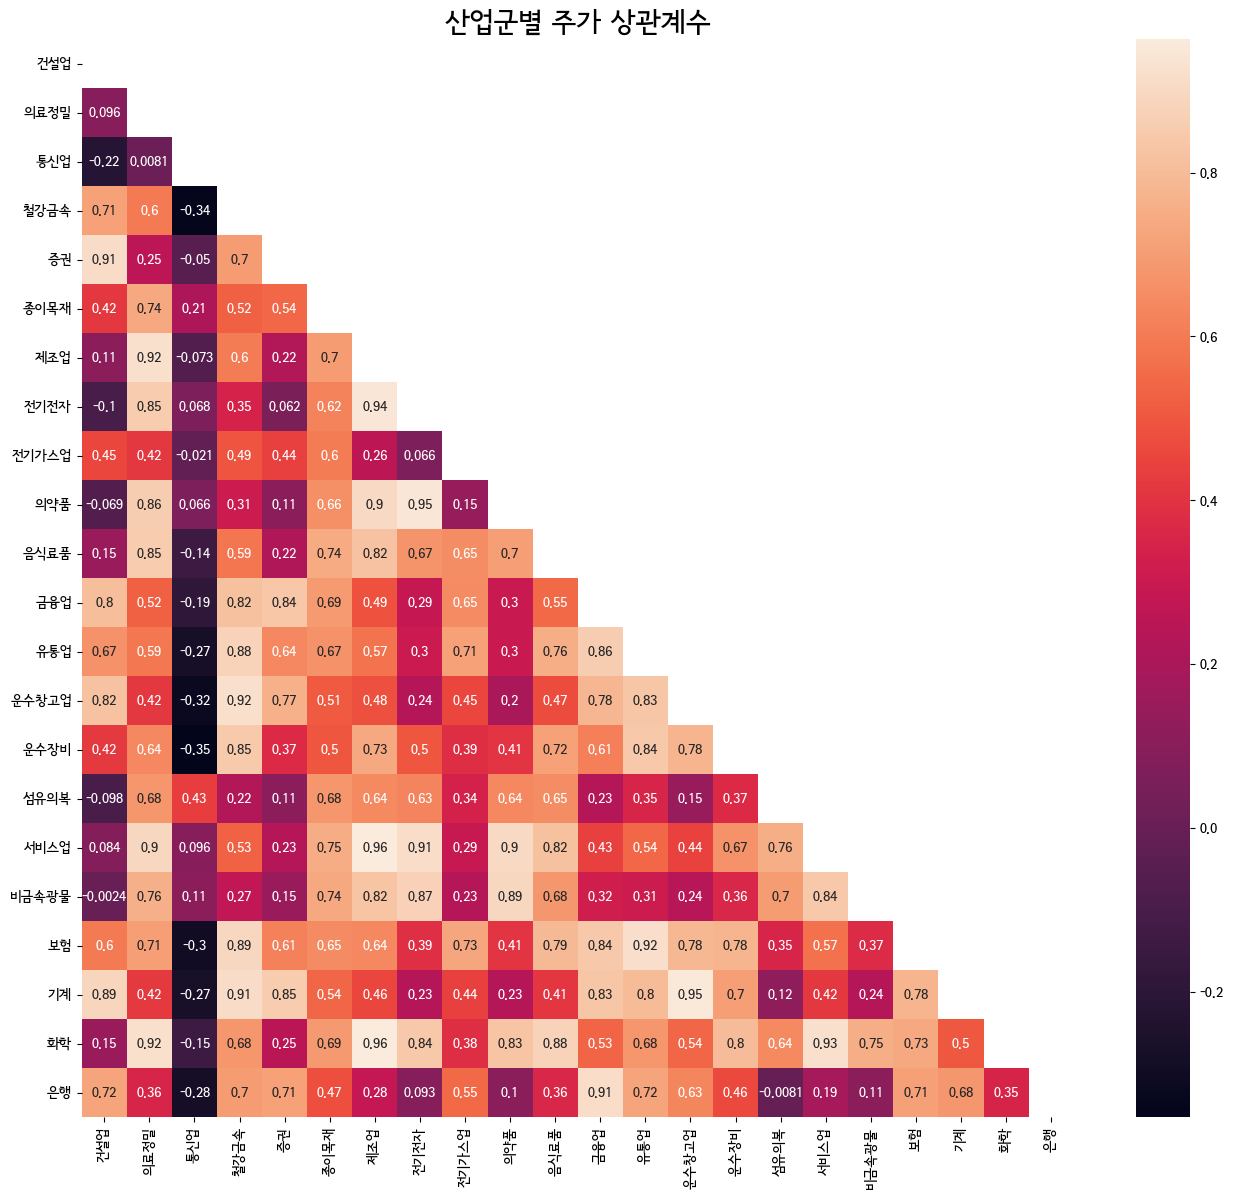

In [181]:
# 산업별 데이터 만들기
df = pd.DataFrame([])
df_sector = pd.read_csv('C:/miniproject_1/data/섹터별_20000101_20220901.csv',encoding='cp949').drop(columns='Unnamed: 0')
df_sector = df_sector.sort_values(by = ['sector_name','date'])[['date','close','sector_name']].reset_index(drop = True)
df['date'] = df_sector['date'].drop_duplicates()
for k,v in df_sector['sector_name'].value_counts().items():
    if k != '코스피':
        df[k] = df_sector.loc[df_sector['sector_name'] == k, 'close'].reset_index(drop = True)

# 시각화
plt.figure(figsize = (16,14))
plt.title('산업군별 주가 상관계수', fontdict = {'fontsize' : 20})
mask = np.triu(np.ones_like(df.set_index('date').corr()))
sns.heatmap(df.set_index('date').corr(), annot = True, mask = mask)

# 종토방 크롤링 하기

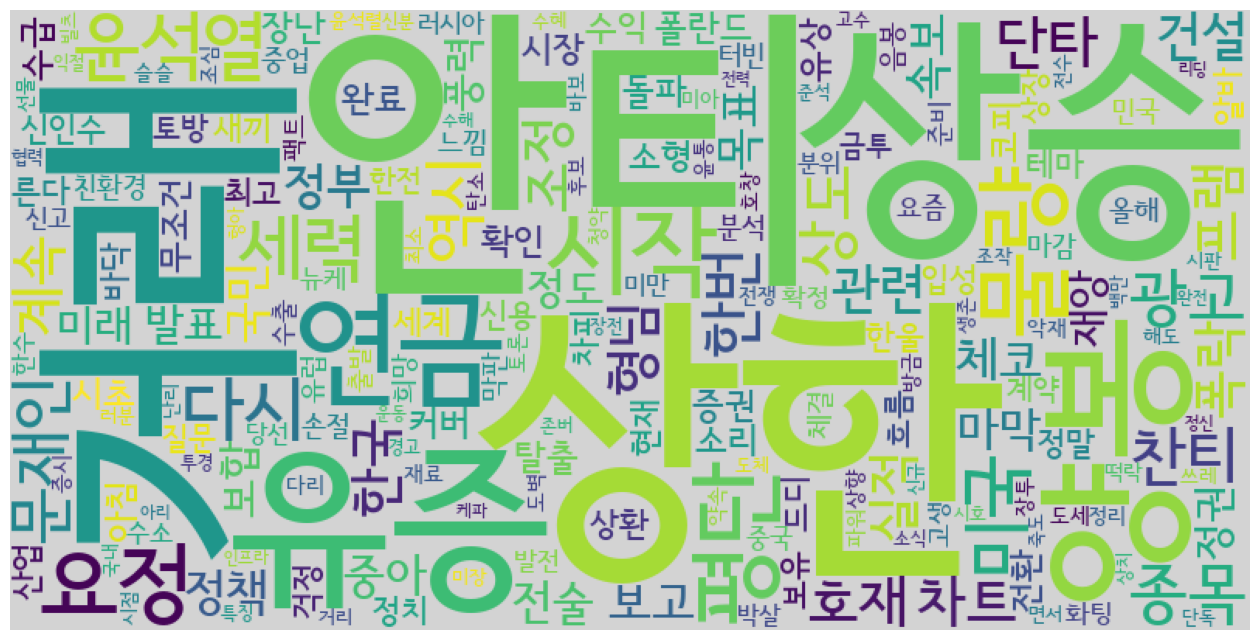

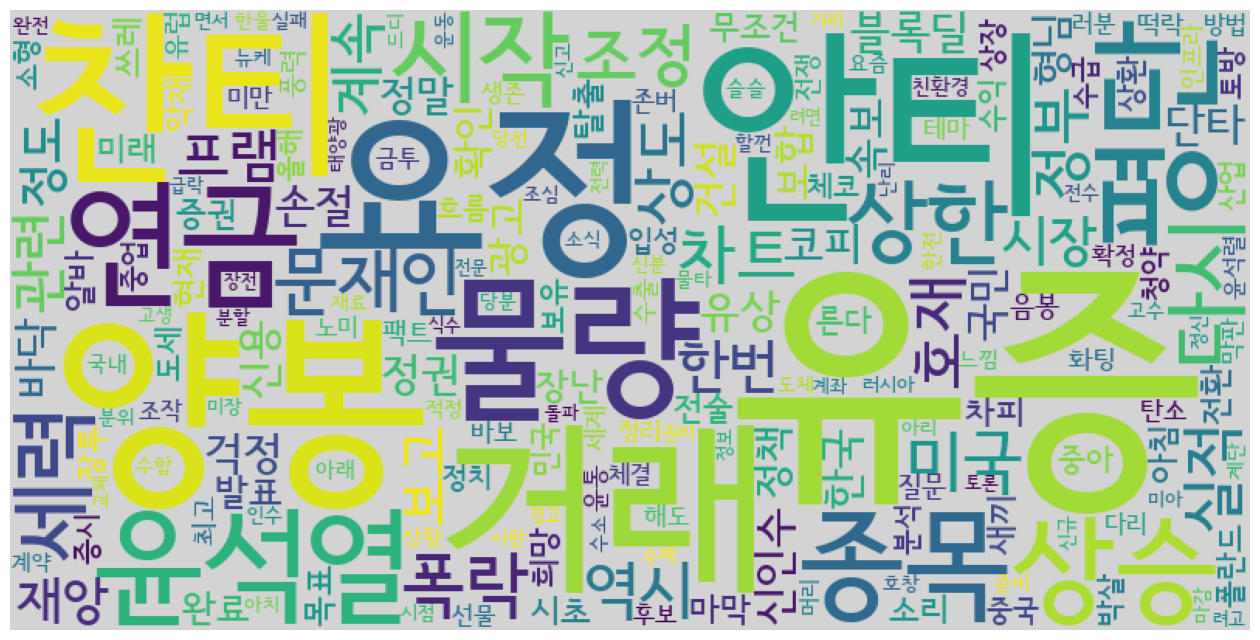

In [184]:
# 크롤링 데이터 불러오기
result_df = pd.read_csv('naver_ds_2023-02-02.csv')
# 크롤링 데이터 날짜 기준으로 새로운 매핑 전용 컬럼 생성
result_df['mapping'] = pd.to_datetime(pd.to_datetime(result_df['날짜']).dt.strftime('%Y-%m-%d'))

# 특정 종목 데이터 불러와서, 등락률에 따라 데이터 분류
df = stock.get_market_ohlcv_by_date(fromdate= result_df.loc[len(result_df) - 1, 'mapping'].strftime(('%Y%m%d')), todate=result_df.loc[0, 'mapping'].strftime(('%Y%m%d')), ticker="034020")
up = df[df['등락률'] >= 0].index # 오른날 혹은 그대로인 날
down = df[df['등락률'] < 0].index # 떨어진날

# 오른날 / 떨어진 날로 데이터 분류
up_result = result_df[result_df['mapping'].isin(up)].reset_index(drop = True)
down_result = result_df[result_df['mapping'].isin(down)].reset_index(drop = True)

# 오른날 기준으로 word_cloud 시각화
word_cloud_jtb(up_result)

# 떨어진 날 기준으로 word_cloud 시각화
word_cloud_jtb(down_result)

In [174]:
result_df

,날짜,제목,조회,공감,비공감,mapping
0,2023.02.02 09:45,주주님들 축하드려요 !!,13,2,0,2023-02-02
1,2023.02.02 09:44,"두산에너빌리티, 확인은 해보셨습니까?",15,2,0,2023-02-02
2,2023.02.02 09:43,이게 두빌이다~~,11,0,0,2023-02-02
3,2023.02.02 09:39,기다리면됩니다,65,1,2,2023-02-02
4,2023.02.02 09:39,보성파워텍 ㄱㄱㄱㄱ,30,0,0,2023-02-02
...,...,...,...,...,...,...
355775,2020.10.06 18:34,2천억이나 쳐먹으면서 실패실패,383,0,1,2020-10-06
355776,2020.10.06 18:27,★★ 올해는 유증물량 소화하기전에는 힘들거 같다,296,0,2,2020-10-06
355777,2020.10.06 18:12,무차입공매도 처벌수위 강화 및 국민연금 주식대여 금지 청원,267,3,0,2020-10-06
355778,2020.10.06 17:57,원전 감사원 발표,2144,24,3,2020-10-06
